## Imports and Setup

In [1]:
# Imports for Tensor
import csv
import itertools
import math
import numpy as np
import os
import pandas as pd
import shutil
import sys
from collections import OrderedDict
from datetime import datetime
from tempfile import TemporaryDirectory
from typing import Tuple

from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from torch import nn, Tensor
from torch.utils.tensorboard import SummaryWriter
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from torchvision import transforms
from torch.optim.swa_utils import AveragedModel, SWALR


from diffusers import StableDiffusionPipeline
from datasets import load_dataset

sys.path.append("../")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from cnn_models import model_size
from cnn_models import CNNClassifier, CNNClassifierLight, LabelSmoothingCrossEntropy
from cnn_models import EfficientNet, ShuffleNet, ResNet
from signal_diffusion.config import load_settings
from signal_diffusion.data.math import MathDataset
from signal_diffusion.data.parkinsons import ParkinsonsDataset
from signal_diffusion.data.seed import SEEDDataset
from signal_diffusion.data.meta import MetaPreprocessor, MetaDataset, MetaSampler
from signal_diffusion.data.meta import general_class_labels, general_dataset_map
from training import train_class, evaluate_class, TrainingConfig
from visualization import *

In [3]:
# cfg_file = "../config/default.toml"
cfg_file = "config/default-mac.toml"
settings = load_settings(cfg_file)

# Data Preprocessing (run once)

In [4]:
# nsamps = 2000

# preprocessor = MITPreprocessor(datadirs['mit'], nsamps, ovr_perc=0.5, fs=250)
# preprocessor.preprocess(resolution=256, train_frac=0.8, val_frac=0.2, test_frac=0.0)

# preprocessor.get_gender('chb01')


In [5]:
# nsamps = 2000

# preprocessor = GeneralPreprocessor(datadirs, nsamps, ovr_perc=0.5, fs=125, bin_spacing="log")
# preprocessor.preprocess(resolution=256, train_frac=0.8, val_frac=0.2, test_frac=0.0)

# STFT Display

file_name                                   train/sub08/spectrogram-0.png
split                                                               train
subject                                                         Subject08
state                                                                   1
gender                                                                  F
doingmath                                                               0
age                                                                    18
fs                                                                  125.0
caption                 an EEG spectrogram of a 18 year old, backgroun...
math_condition                                                          1
math_condition_label                                         bkgnd_female
Name: 556, dtype: object


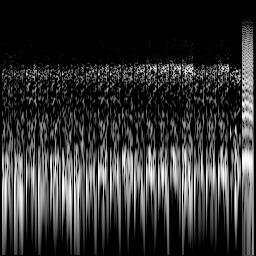

file_name                                    test/sub00/spectrogram-0.png
split                                                                test
subject                                                         Subject00
state                                                                   1
gender                                                                  F
doingmath                                                               0
age                                                                    17
fs                                                                  125.0
caption                 an EEG spectrogram of a 17 year old, backgroun...
math_condition                                                          1
math_condition_label                                         bkgnd_female
Name: 681, dtype: object


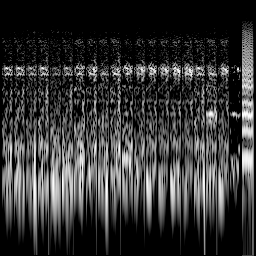

file_name                                        test/sub-003/spectrogram-0.png
split                                                                      test
subject                                                                 sub-003
gender                                                                        F
health                                                                       PD
age                                                                          68
fs                                                                        125.0
caption                       an EEG spectrogram of a 68 year old, parkinson...
parkinsons_condition                                                          3
parkinsons_condition_label                                    parkinsons_female
Name: 2585, dtype: object


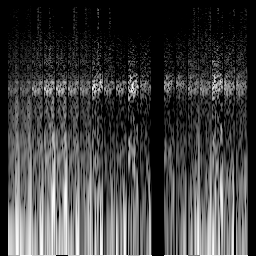

file_name                                         val/sub-006/spectrogram-0.png
split                                                                       val
subject                                                                 sub-006
gender                                                                        M
health                                                                       PD
age                                                                          69
fs                                                                        125.0
caption                       an EEG spectrogram of a 69 year old, parkinson...
parkinsons_condition                                                          2
parkinsons_condition_label                                      parkinsons_male
Name: 2421, dtype: object


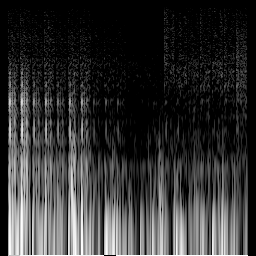

In [6]:
# Math male subject
display_stft(settings, 'math', sub_ind=9, spec_ind=0)

# Math female subject
display_stft(settings, 'math', sub_ind=0, spec_ind=0)

# Parkinsons male subject
display_stft(settings, 'parkinsons', sub_ind=4, spec_ind=0)

# Parkinsons female subject
display_stft(settings, 'parkinsons', sub_ind=7, spec_ind=0)

# Seed male subject
# display_stft(settings, 'seed', sub_ind=2, spec_ind= 0)

# Seed female subject
# display_stft(settings, 'seed', sub_ind=1, spec_ind=10)

# Train on Real Data

## Dataloader Setup

In [7]:
# Parameters
BATCH_SIZE = 32
SHUFFLE = True
NUM_WORKERS = 4
N_TOKENS = 128
RESOLUTION = 256
HOP_LENGTH = 80
persistent = NUM_WORKERS > 0

# Data augmentation
randtxfm = transforms.Compose([
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

In [8]:
# MetaDataset configuration
train_dataset_names = ("parkinsons", "math")
target_tasks = ("gender",)

val_set = MetaDataset(
    settings,
    train_dataset_names,
    split="val",
    tasks=target_tasks,
    target_format="tuple",
)

real_train_set = MetaDataset(
    settings,
    train_dataset_names,
    split="train",
    tasks=target_tasks,
    transform=randtxfm,
    target_format="tuple",
)

train_samp = MetaSampler(real_train_set, num_samples=len(real_train_set))


In [9]:
# Dataloaders
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE,
                                         num_workers=NUM_WORKERS, pin_memory=True,
                                         persistent_workers=persistent)
real_train_loader = torch.utils.data.DataLoader(real_train_set, batch_size=BATCH_SIZE,
                                                num_workers=NUM_WORKERS, pin_memory=True,
                                                persistent_workers=persistent, sampler=train_samp)

In [10]:
# Define hyper paramters
L2_REG_DECAY = 0.1
EPOCHS = 5
SWA_START = 3
BASE_LEARNING_RATE = .01
SWA_LEARNING_RATE = 0.05
EPSILON = 0.1
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR #torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
# scheduler = torch.optim.lr_scheduler.ConstantLR
optimizer = torch.optim.AdamW # torch.optim.SGD

# Constant params
OUTPUT_DIM = 2
DROPOUT = 0.5
BATCH_FIRST = True # True: (batch, seq, feature). False: (seq, batch, feature)

# CUDA for PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
torch.backends.cudnn.benchmark = device.type == "cuda"

# Create hip_dict
hip_dict = {'L2_Decay': L2_REG_DECAY, 'Epochs': EPOCHS, 'Swa_Start': SWA_START, 'base_lr"': BASE_LEARNING_RATE, }

In [11]:
random_seed = 205 #205 Gave a good split for training
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Loss function
criterion = LabelSmoothingCrossEntropy(epsilon=EPSILON)

# Optimizer
opt = optimizer
decay = L2_REG_DECAY

# Create model instance
model = CNNClassifierLight(1, OUTPUT_DIM, dropout=DROPOUT,pooling="max")
model = model.to(device)

if opt == torch.optim.AdamW:
    optimizer = opt(model.parameters(), lr=BASE_LEARNING_RATE, weight_decay=decay)
elif opt == torch.optim.SGD:
    # BASE_LEARNING_RATE = BASE_LEARNING_RATE * 100
    # optimizer = opt(model.parameters(), lr=BASE_LEARNING_RATE, weight_decay=decay, momentum = 0.5)
    optimizer = opt(model.parameters(), lr=BASE_LEARNING_RATE)

if scheduler == torch.optim.lr_scheduler.ExponentialLR:
    exp_sched_gamma = 0.9
    scheduler = scheduler(optimizer, exp_sched_gamma, verbose=False, last_epoch=- 1)
elif scheduler == torch.optim.lr_scheduler.CosineAnnealingLR:
    scheduler = scheduler(optimizer, T_max=int(3), last_epoch=- 1)
elif scheduler == torch.optim.lr_scheduler.CosineAnnealingWarmRestarts:
    scheduler = scheduler(optimizer, T_0=EPOCHS, last_epoch=- 1)
elif scheduler == torch.optim.lr_scheduler.ConstantLR:
    scheduler = scheduler(optimizer, factor=1, total_iters=EPOCHS)

# SWA model instance
if SWA_START < EPOCHS:
    swa_model = AveragedModel(model)
    swa_scheduler = SWALR(optimizer, swa_lr=SWA_LEARNING_RATE,
                          anneal_epochs=2, anneal_strategy='linear', last_epoch=-1 )
else:
    swa_model = None
    swa_scheduler = None

# Create training configuration
ARGS = TrainingConfig(epochs=EPOCHS, val_every_epochs=1, swa_start=SWA_START)

# Log statistics
optimizer_name = type(optimizer).__name__.lower()
scheduler_name = scheduler.__class__.__name__ if scheduler else "none"
comment_parts = [
    f"model={model.name}",
    f"opt={optimizer_name}",
    f"decay={decay}",
    f"epochs={EPOCHS}",
    f"swa_start={SWA_START}",
    f"base_lr={BASE_LEARNING_RATE}",
    f"swa_lr={SWA_LEARNING_RATE}",
    f"epsilon={EPSILON}",
    f"sched={scheduler_name}",
    f"dropout={DROPOUT}",
]
comment_summary = ",".join(comment_parts)
run_comment = f"{comment_summary},date={datetime.now().isoformat(sep='_')}"
log_dir = os.path.join("./tensorboard_logs/cnn", run_comment)
tbsw = SummaryWriter(log_dir=log_dir, comment=run_comment)
print("#" * 80)
print("Training", run_comment)


################################################################################
Training model=CNNClassifierLight,opt=adamw,decay=0.1,epochs=5,swa_start=3,base_lr=0.01,swa_lr=0.05,epsilon=0.1,sched=CosineAnnealingLR,dropout=0.5,date=2025-09-20_21:15:59.067684


In [12]:
# Training loop
losses, accs, val_accs, ema_val_accs = train_class(
    ARGS, model, swa_model,
    real_train_loader, val_loader,
    optimizer, scheduler,
    criterion, device, tbsw, run_comment,
    save_model=False,
    swa_scheduler=swa_scheduler,
)



  0%|          | 0/435 [00:00<?, ?it/s]

/Users/jsanz/git/signal-diffusion/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [13]:
# Load checkpoints and record artifacts
# model.load_state_dict(torch.load('best_model.pt'))
# best_swa_model = copy.deepcopy(model)
# best_swa_model.load_state_dict(torch.load('best_swa_model.pt'))
# swa_model = copy.deepcopy(model)
# swa_model.load_state_dict(torch.load('last_swa_model.pt'))

# os.makedirs('models', exist_ok=True)
# shutil.copyfile('best_model.pt', f'models/best_model-{run_comment}.pt')
# shutil.copyfile('last_model.pt', f'models/last_model-{run_comment}.pt')
# print(f"Copied best model to models/best_model-{run_comment}.pt")

rmodel = model


## Train

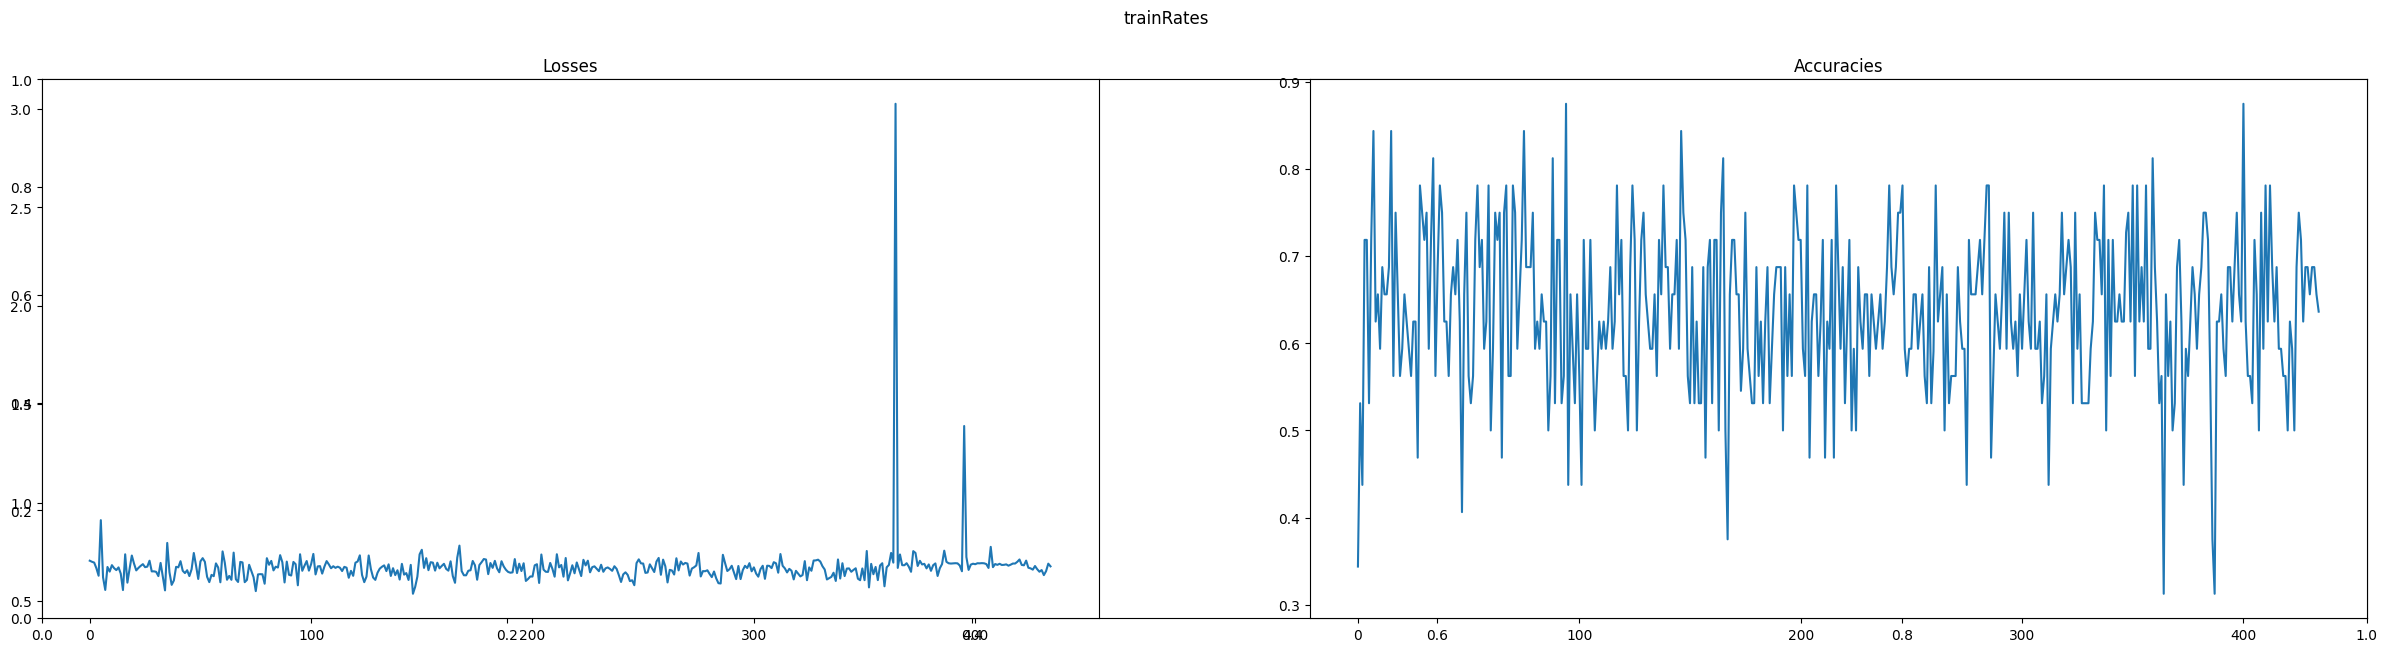

In [14]:
train_vs_epoch(losses, accs, 'train')

In [16]:
# plt.figure(figsize=(40,15))
# plt.plot(range(len(lrs)), lrs)

In [17]:
#display_conv_weights(model.convs)

In [18]:
# class_prevalence(real_train_loader, general_class_labels);

87


Text(0.5, 1.0, 'MAIN Training')

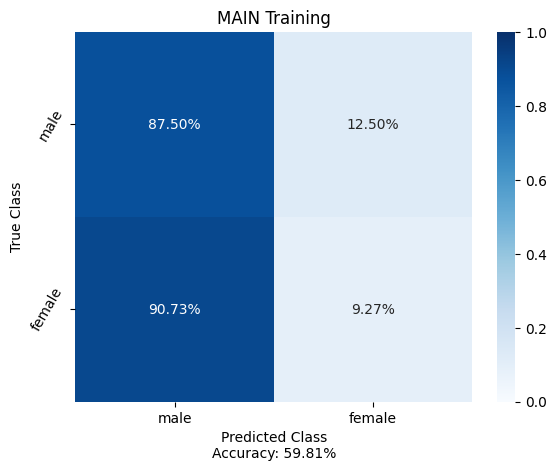

In [19]:
cf, p = class_confusion(rmodel, real_train_loader, general_class_labels, device)
plt.title("MAIN Training")

87


Text(0.5, 1.0, 'SWA Training')

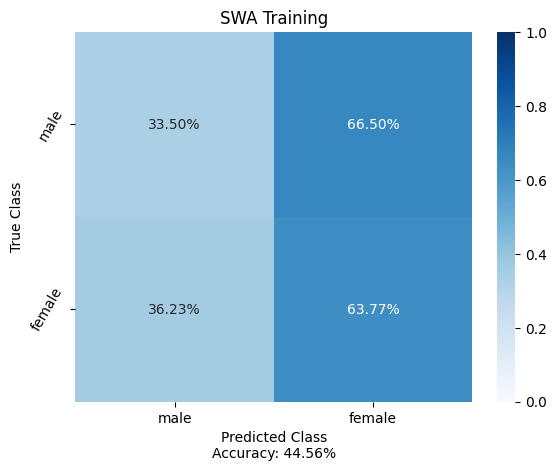

In [22]:
cf, p = class_confusion(swa_model, real_train_loader, general_class_labels, device)
plt.title("SWA Training")

13


Text(0.5, 1.0, 'Validation')

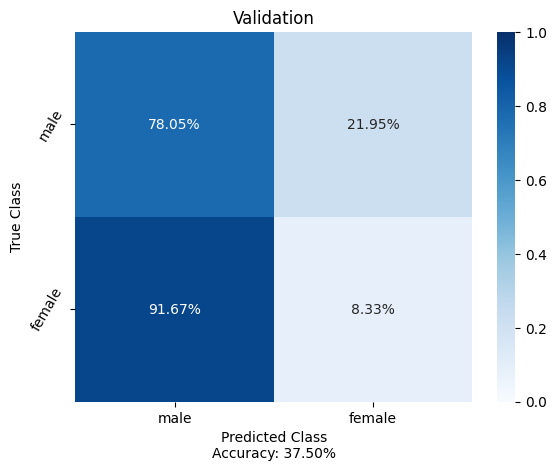

In [23]:
cf, p = class_confusion(rmodel, val_loader, general_class_labels, device)
plt.title("Validation")

13


Text(0.5, 1.0, 'Validation: Final SWA')

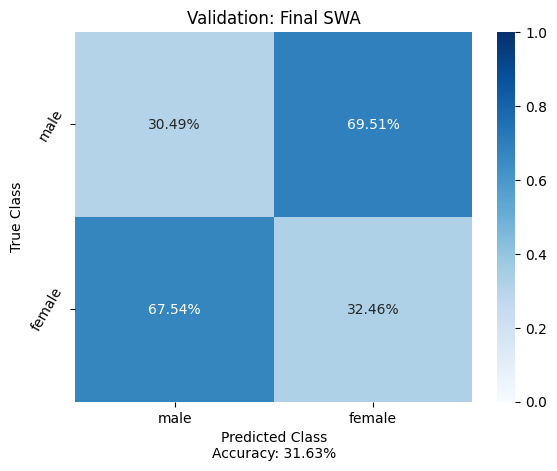

In [24]:
cf, p = class_confusion(swa_model, val_loader, general_class_labels, device)
plt.title("Validation: Final SWA")

In [ ]:
cf, p = class_confusion(best_swa_model, val_loader, general_class_labels, device)
plt.title("Validation: Best SWA")

(<Figure size 600x400 with 1 Axes>,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

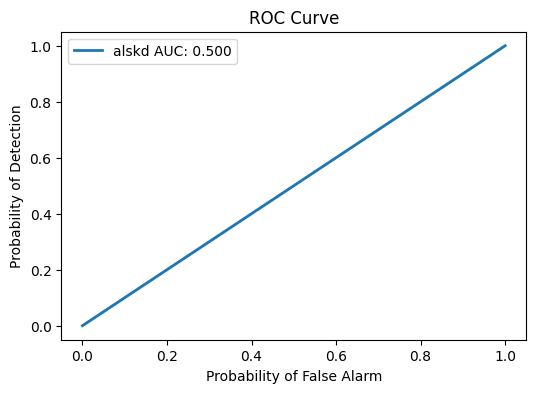

In [25]:
roc(model, val_loader, label="alskd")

In [ ]:
for dataset in real_train_datasets:
    real_train_set = GeneralDataset([dataset], split='train')

    real_train_loader = torch.utils.data.DataLoader(real_train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE,
                                                num_workers=NUM_WORKERS, pin_memory=True,
                                                persistent_workers=persistent)


    train_loss, train_acc = evaluate_class(model, real_train_loader, criterion, device,
                                     tbsw, ARGS.epochs * len(real_train_loader) + 1, 'gender')
    cf, p = class_confusion(rmodel, real_train_loader, general_class_labels, device)
    plt.title("Train")

In [ ]:
for dataset in val_datasets:
    test_set = GeneralDataset([dataset], split='val')

    test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE,
                                                num_workers=NUM_WORKERS, pin_memory=True,
                                                persistent_workers=persistent)
    test_loss, test_acc = evaluate_class(model, test_loader, criterion, device,
                                     tbsw, ARGS.epochs * len(real_train_loader) + 1, 'gender')
    print(f'Val loss={test_loss:.3f}; Val accuracy={test_acc:.3f}')
    cf, p = class_confusion(rmodel, test_loader, general_class_labels, device)
    plt.title("Validation")

In [ ]:
subject_prevalence(real_train_datasets)

In [ ]:
subject_prevalence(val_datasets)

In [ ]:
# subject_prevalence(test_datasets)

In [ ]:
dataset_prevalence(real_train_datasets, general_dataset_map)

In [ ]:
class_prevalence(real_train_loader, general_class_labels);

In [ ]:
class_prevalence(val_loader, general_class_labels);

In [ ]:
subject_prevalence(val_datasets)

In [ ]:
class_prevalence(test_loader, general_class_labels);

# ----------------------------------------Stop-------------------------------------------

# Generate a fake dataset

# Generated Spectrograms

In [ ]:
gendir = "/data/shared/signal-diffusion/parkinsons/gen-stft.1/"


In [ ]:
gen_set = GeneratedSpectrumDataset(gendir)
print(len(gen_set))
print(gen_set[0])

## Generative-Trained Classifier

In [ ]:
# Parameters

# Data augmentation
randtxfm = transforms.Compose([
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# Datasets
train_set = GeneratedSpectrumDataset(gendir, transform=randtxfm)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                           shuffle=SHUFFLE, num_workers=NUM_WORKERS,
                                           pin_memory=True, persistent_workers=persistent)

noaug_train_set = GeneratedSpectrumDataset(gendir, transform=None)
noaug_train_loader = torch.utils.data.DataLoader(noaug_train_set, batch_size=BATCH_SIZE,
                                           shuffle=SHUFFLE, num_workers=NUM_WORKERS,
                                           pin_memory=True, persistent_workers=persistent)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE,
                                         shuffle=SHUFFLE, num_workers=NUM_WORKERS,
                                         pin_memory=True, persistent_workers=persistent)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                          shuffle=SHUFFLE, num_workers=NUM_WORKERS,
                                          pin_memory=True, persistent_workers=persistent)

In [ ]:
# define hyperparameters
OUTPUT_DIM = 4
DROPOUT = 0.5
BATCH_FIRST = True # True: (batch, seq, feature). False: (seq, batch, feature)
WEIGHT_DECAY = 0.0001

# CUDA for PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
torch.backends.cudnn.benchmark = device.type == "cuda"

# Loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# Runtime training parameters
opt = torch.optim.AdamW
decay = 0.01


# Create model instance
model = CNNClassifier(1, OUTPUT_DIM, dropout=DROPOUT)
model = model.to(device)
optimizer = opt(model.parameters(), lr=1e-3, weight_decay=decay)

# Create training configuration
ARGS = TrainingConfig(epochs=30, val_every_epochs=3)

# Log statistics
postfix = ""
comment = f"cnnclass_gen_{str(type(optimizer)).split('.')[-1][:-2]}_decay{decay}{postfix}"
tbsw = SummaryWriter(log_dir="./tensorboard_logs/cnn/" + comment + "-" +
                     datetime.now().isoformat(sep='_'),
                     comment=comment)
print("#" * 80)
print("Training", comment)

# Training loop
losses, accs, val_accs = train_class(
    ARGS, model,
    train_loader, val_loader,
    optimizer, criterion,
    device, tbsw
)

# load best model and evaluate on test set
model.load_state_dict(torch.load(f'best_model.pt'))
test_loss, test_acc = evaluate_class(model, test_loader, criterion, device,
                                     tbsw, ARGS.epochs * len(train_loader) + 1)
print(f'Test loss={test_loss:.3f}; test accuracy={test_acc:.3f}')

# Copy model to unique filename
os.makedirs("models", exist_ok=True)
shutil.copyfile("best_model.pt", f"models/best_model-{run_comment}.pt")
shutil.copyfile("last_model.pt", f"models/last_model-{run_comment}.pt")
print(f"Copied best model to models/best_model-{run_comment}.pt")

gmodel = model

### Evaluate on generative data

In [ ]:
cf, p = class_confusion(gmodel, train_loader, parkinsons_class_labels, device)
plt.title("Gen-train, Gen-test")

### Evaluate on real data

In [ ]:
cf, p = class_confusion(gmodel, real_train_loader, parkinsons_class_labels, device)
plt.title("Gen-train, Real-test")

In [ ]:
cf, p = class_confusion(gmodel, test_loader, parkinsons_class_labels, device)
plt.title("Gen-train, Real-test")

In [ ]:
class_prevalence(train_loader, parkinsons_class_labels);

## Real-trained classifier on generative data

In [ ]:
rmodel = CNNClassifier(1, OUTPUT_DIM,)
rmodel.load_state_dict(torch.load("models/best_model-cnnclass_AdamW_decay0.001.pt"))
rmodel.to("cuda")

### Evaluate on generative data

In [ ]:
cf, p = class_confusion(rmodel, noaug_train_loader, parkinsons_class_labels, device)
plt.title("Real-train, Gen-test")

### Evaluate on real data

In [ ]:
cf, p = class_confusion(rmodel, test_loader, parkinsons_class_labels, device)
plt.title("Real-train, Real-test")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.subplot(2, 2, 1)
cf, _ = class_confusion(rmodel, test_loader, parkinsons_class_labels, device, fig=fig)
plt.title("Real-train, Real-test")
plt.yticks(rotation=60)
plt.xticks([])
plt.xlabel("Accuracy: {:.2%}".format(np.trace(cf) / np.sum(cf)))
plt.ylabel("True Class")

plt.subplot(2, 2, 2)
cf, _ = class_confusion(rmodel, noaug_train_loader, parkinsons_class_labels, device, fig=fig)
plt.xticks([])
plt.xlabel("Accuracy: {:.2%}".format(np.trace(cf) / np.sum(cf)))
plt.yticks([])
plt.title("Real-train, Gen-test")

plt.subplot(2, 2, 3)
cf, _ = class_confusion(gmodel, test_loader, parkinsons_class_labels, device, fig=fig)
plt.title("Gen-train, Real-test")
plt.xlabel("Predicted Class\nAccuracy: {:.2%}".format(np.trace(cf) / np.sum(cf)))
plt.yticks(rotation=60)
plt.xticks(rotation=60)

plt.subplot(2, 2, 4)
cf, _ = class_confusion(gmodel, noaug_train_loader, parkinsons_class_labels, device, fig=fig)
plt.yticks([])
plt.xticks(rotation=60)
plt.xlabel("Predicted Class\nAccuracy: {:.2%}".format(np.trace(cf) / np.sum(cf)))
plt.title("Gen-train, Gen-test")

plt.subplots_adjust(bottom=0.2)

## Train on both

In [ ]:
# Datasets
both_set = torch.utils.data.ConcatDataset([real_train_set, train_set])
both_loader = torch.utils.data.DataLoader(both_set, batch_size=BATCH_SIZE,
                                          shuffle=SHUFFLE, num_workers=NUM_WORKERS,
                                          pin_memory=True, persistent_workers=persistent)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE,
                                         shuffle=SHUFFLE, num_workers=NUM_WORKERS,
                                         pin_memory=True, persistent_workers=persistent)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                          shuffle=SHUFFLE, num_workers=NUM_WORKERS,
                                          pin_memory=True, persistent_workers=persistent)

In [ ]:
# Runtime training parameters
opt = torch.optim.AdamW
decay = 0.01


# Create model instance
model = CNNClassifier(1, OUTPUT_DIM, dropout=DROPOUT)
model = model.to(device)
optimizer = opt(model.parameters(), lr=1e-3, weight_decay=decay)

# Create training configuration
ARGS = TrainingConfig(epochs=15, val_every_epochs=1)

# Log statistics
postfix = ""
comment = f"cnnclass_both_{str(type(optimizer)).split('.')[-1][:-2]}_decay{decay}{postfix}"
tbsw = SummaryWriter(log_dir="./tensorboard_logs/cnn/" + comment + "-" +
                     datetime.now().isoformat(sep='_'),
                     comment=comment)
print("#" * 80)
print("Training", comment)

# Training loop
losses, accs, val_accs = train_class(
    ARGS, model,
    both_loader, val_loader,
    optimizer, criterion,
    device, tbsw
)

# load best model and evaluate on test set
model.load_state_dict(torch.load(f'best_model.pt'))
test_loss, test_acc = evaluate_class(model, test_loader, criterion, device,
                                     tbsw, ARGS.epochs * len(train_loader) + 1)
print(f'Test loss={test_loss:.3f}; test accuracy={test_acc:.3f}')

# Copy model to unique filename
os.makedirs("models", exist_ok=True)
shutil.copyfile("best_model.pt", f"models/best_model-{run_comment}.pt")
shutil.copyfile("last_model.pt", f"models/last_model-{run_comment}.pt")
print(f"Copied best model to models/best_model-{run_comment}.pt")

bmodel = model

In [ ]:
cf, p = class_confusion(bmodel, test_loader, parkinsons_class_labels, device)
plt.title("Both-train, Real-test")

In [ ]:
cf, p = class_confusion(bmodel, noaug_train_loader, parkinsons_class_labels, device)
plt.title("Both-train, Gen-test")